In [1]:
from typing import Dict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset

In [4]:
from pathlib import Path

In [5]:
from tqdm import tqdm_notebook as tqdm

In [6]:
from torchvision import transforms, datasets

In [7]:
import os
import requests

In [8]:
import json

In [9]:
from os import listdir
from os.path import isfile, join

In [10]:
from google_drive_downloader import GoogleDriveDownloader as gd

In [11]:
import tarfile

In [12]:
def download_data(file_id: str, dest_path: str):
    gd.download_file_from_google_drive(file_id=file_id, dest_path=dest_path)
    tar = tarfile.open(dest_path, "r:gz")
    tar.extractall()
    tar.close()
    remove()

In [23]:
# download_data(file_id='1UKApRnqpepFgm9vb8JeqhDvejpqX-tas', dest_path='./anime/faces.tar.gz')

In [13]:
def read_images_content(filepath: Path):
    files = [f for f in listdir(filepath) if isfile(join(filepath, f))]
    dirname = os.path.basename(filepath)
    images = [plt.imread(dirname + '/' + f) for f in files]
    return images

In [14]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((28, 28)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [15]:
class AnimeDataset(Dataset):
    def __init__(self, data_file: Path, transform=None):
        self.data = read_images_content(data_file)
        self.transform = transform

    def __getitem__(self, index: int) -> torch.Tensor:
        sample = self.data[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.data)

In [16]:
data = AnimeDataset(Path('faces/'), transform=transform)

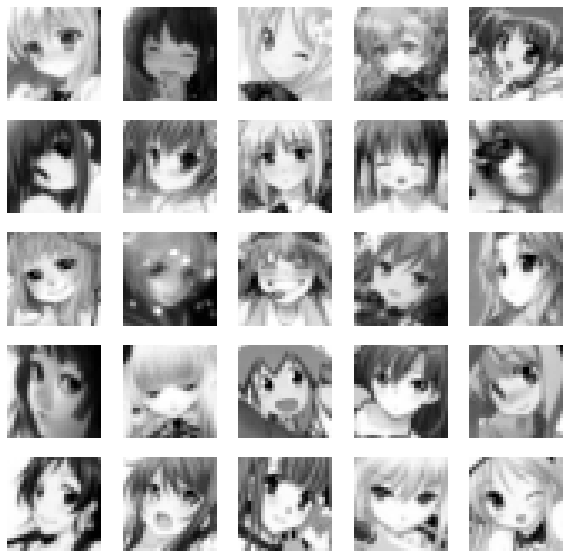

In [17]:
ind = np.random.randint(1, high=len(data), size=25)
pokemons = [data[i] for i in ind]
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(pokemons[i*5 + j].reshape(28, 28), cmap='gray')
        ax[i,j].axis('off')

In [18]:
batch_size = 100
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(dataloader)

In [19]:
IMG_SIZE = 784
LAYER_SIZE_1 = 512
LAYER_SIZE_2 = 256
LATENT_DIM = 128
EXPAND_DIM = 1024
FEAT_SIZE = 784
WIDTH = 256
HEIGHT = 256

In [20]:
def contracting_conv(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
                 kernel_size=(4, 4),
                 stride=2,
                 padding=1,
                 bias=False)

In [21]:
def expanding_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(in_channels, out_channels,
                          kernel_size=(4, 4),
                          stride=2,
                          padding=1,
                          bias=False)

In [22]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, negative_slope=0.2):
        super().__init__()
        out_channels = in_channels * 2
        self.hidden = nn.Sequential(
    contracting_conv(in_channels, out_channels),
    nn.BatchNorm2d(out_channels),
    nn.LeakyReLU(negative_slope=negative_slope)
    )

    def forward(self, x):
        return self.hidden(x)

In [23]:
class ExpandingBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels // 2
        self.hidden = nn.Sequential(
    expanding_conv(in_channels, out_channels),
    nn.BatchNorm2d(out_channels),
    nn.ReLU()
    )

    def forward(self, x):
        return self.hidden(x)

In [77]:
class Discriminator(nn.Module):
    def __init__(self, negative_slope=0.2):
        super().__init__()
        self.conv1 = nn.Sequential(
            contracting_conv(1, 128),
            nn.LeakyReLU(negative_slope))
        self.hidden = nn.Sequential(
            ContractingBlock(128),
            ContractingBlock(256),
            ContractingBlock(512))
        self.out = nn.Sequential(
            nn.Linear(1024*1*1, 1),
            nn.Sigmoid())

    @property
    def device(self) -> torch.device:
        return self.out[0].weight.device

    def forward(self, x):
        x = self.conv1(x)
        x = self.hidden(x)
        x = x.view(-1, 1024*1*1)
        x = self.out(x)
        return x

In [78]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.normal = Normal(loc=0., scale=1.)

        self.fc = nn.Linear(100, 1024*1*1)
        self.hidden = nn.Sequential(
            ExpandingBlock(1024),
            ExpandingBlock(512),
            ExpandingBlock(256))
        self.out = nn.Sequential(
            expanding_conv(128, 1),
            nn.Tanh())

    @property
    def device(self) -> torch.device:
        return self.out[0].weight.device

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 1024, 1, 1)
        x = self.hidden(x)
        x = self.out(x)
        return x

    def noise(self, sample_size: int) -> torch.Tensor:
        z = self.normal.sample(sample_shape=(sample_size, 100)).to(self.device)
        return z

    def sample(self, sample_size: int) -> torch.Tensor:
        z = self.noise(sample_size)
        return self(z)

In [79]:
discriminator = Discriminator()
generator = Generator()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [80]:
learning_rate = 0.0002

In [81]:
d_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optim = optim.Adam(generator.parameters(), lr=learning_rate)

In [82]:
loss_function = nn.BCELoss()

In [83]:
def ones_tensor(size, device):
    t = torch.ones(size).unsqueeze(-1).to(device)
    return t


def zeros_tensor(size, device):
    t = torch.zeros(size).unsqueeze(-1).to(device)
    return t

In [84]:
def discriminator_step(discriminator, loss_function, true_data, fake_data, optimizer=None):
    shape = true_data.size(0)
    device = true_data.device
    true_output = discriminator(true_data)
    true_loss = loss_function(true_output, ones_tensor(shape, device))
    fake_output = discriminator(fake_data)
    fake_loss = loss_function(fake_output, zeros_tensor(shape, device))
    loss = true_loss + fake_loss
    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

In [85]:
def generator_step(discriminator, loss_function, fake_data, optimizer=None):
    shape = fake_data.size(0)
    device = fake_data.device
    output = discriminator(fake_data)
    loss = loss_function(output, ones_tensor(shape, device))
    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

In [86]:
def images_to_vectors(images, n_features=IMG_SIZE):
    return images.view(images.size(0), n_features)

In [87]:
def plot_sample_images(generator, cols=5, rows=5, width=28, height=28, figsize=(10, 10)):
    sample = generator.sample(cols * rows).data.cpu().numpy()
    fig, ax = plt.subplots(cols, rows, sharex='col', sharey='row', figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            ax[i,j].imshow(sample[i*rows + j].reshape(width, height), cmap='gray')
            ax[i,j].axis('off')

In [88]:
def train_gan(loss_function, num_epochs=100):
    device = discriminator.device
    d_losses = []
    g_losses = []
    for epoch in range(num_epochs):
        print(f'\r epoch: [{epoch+1}/{num_epochs}]', end='')
        d_loss, g_loss, b = 0, 0, 0
        for batch in tqdm(dataloader, ncols=340, desc=f'Epoch {epoch + 1}'):
            true_data = batch.to(device).float()
            sample_size = true_data.size(0)
            fake_data = generator.sample(sample_size).detach()
            discriminator_loss = discriminator_step(discriminator, loss_function, true_data, fake_data, d_optim)
            fake_data = generator.sample(sample_size)
            generator_loss = generator_step(discriminator, loss_function, fake_data, g_optim)
            d_loss += discriminator_loss.data.cpu()
            g_loss += generator_loss.data.cpu()
            b += 1
        d_loss /= float(b)
        g_loss /= float(b)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
#         plot_sample_images(generator)
    return d_losses, g_losses

In [89]:
num_epochs = 1
d_losses, g_losses = train_gan(loss_function, num_epochs=num_epochs)

 epoch: [1/1]

KeyboardInterrupt: 

In [ ]:
images = generator.sample(25).data.cpu().numpy()
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[i*5 + j].squeeze(), cmap='gray')
        ax[i,j].axis('off')


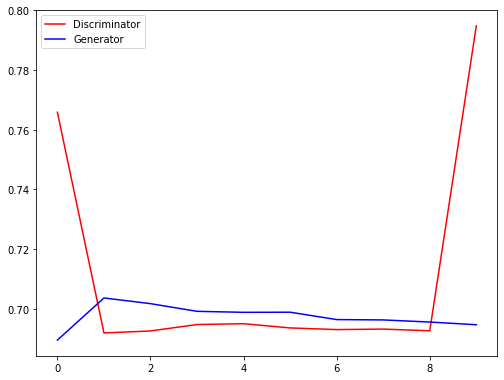

In [109]:
epochs = np.arange(num_epochs)
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(epochs, d_losses, color='r', label='Discriminator')
axes.plot(epochs, g_losses, color='b', label='Generator')
axes.legend();